## Overview:
We are using the 2009 H1n1 and Flu vaccine survey. It is a multilabel, multiclass dataset. There are four possible classes (four sets of twos). 


#### Before proceeding, it is useful to read about approaches to modelling multilabel, multiclass target data. 

These are a few of the papers and writings we consulted:
    

    
We needed to consider the complexity/number of labels and classifiers, computational complexity, models' tendencies
to overfit, data imbalance, and multicollinearity. Should we treat label combinations as unique sets? 


### Now we look at the data to get a better idea of what we're working with

We have four files prepared for us already: training features and training labels, and test features and test labels.
Should we use this split? Let's look at the breakdowns of target features in test vs train. If needed, we can combine
the data and create our own splits.

In [1]:
# imports

# basic dataframes and math
import pandas as pd
import numpy as np
import scipy.stats as stats
import math
import itertools as IT
import scipy.stats as stats
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from ydata_profiling import ProfileReport

# geo data
import geopy.geocoders
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Bing
import reverse_geocoder as rg



# possible models and related features




from sklearn.pipeline import Pipeline

# models, preprocessing and evaluation


from sklearn.model_selection import train_test_split as tts
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score
# more metrics!

from catboost import Pool, CatBoostClassifier
import statsmodels.api as sm
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, MaxAbsScaler, QuantileTransformer,MultiLabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, StackingClassifier
from sklearn.svm import SVC


# warnings, misc.
import warnings
warnings.filterwarnings('ignore')

In [2]:

train_features_1 = pd.read_csv('/Users/admin/Documents/Flatiron/Vaccine-Predictions-2009/data/training_set_features.csv')
train_targets_1 = pd.read_csv('/Users/admin/Documents/Flatiron/Vaccine-Predictions-2009/data/training_set_labels.csv')
test_features_1 = pd.read_csv('/Users/admin/Documents/Flatiron/Vaccine-Predictions-2009/data/test_set_features.csv')


In [3]:
# since we are not given our test y(labels) data, I suppose we have to re-create the original dataset and then split it? 
# let's see if our train features and targets are even the same length

np.testing.assert_array_equal(train_features_1.index.values, train_targets_1.index.values)

# no error, so they do match. so where do we get our test data from?
print(train_features_1.shape)
print(train_targets_1.shape)
print(test_features_1.shape)

# hmm, it appears that perhaps the train and test features are in fact the same data, implying we do, in fact,
# need to merge and split fresh. let's look closer

(26707, 36)
(26707, 3)
(26708, 36)


In [4]:
# let's look  at the id numbers, which are pre-given to us as unique
train_features_1.columns
train_features_1['respondent_id'].value_counts()
test_features_1.columns
test_features_1['respondent_id'].value_counts()
train_features_1.assign(Intest_features_1=train_features_1.respondent_id.isin(test_features_1.respondent_id).astype(int))
# no, these all appear unique. let's be certain. 
print(train_features_1.respondent_id.isin(test_features_1.respondent_id).value_counts())

# yes, they're all unique. so the data was just split in half between test and training. i don't understand how
# we're supposed to generate test targets to validate against? unless they're just still inside the test data?


False    26707
Name: respondent_id, dtype: int64


In [5]:
train_targets_1.info()

test_features_1.columns

# no, the targets are not in the test data. should we just split up our training data since
# at least it's complete and not use the test set except for making predictions? clearly we can't evaluate 
# our results without test targets. this is how most people did it on github. or should we merge all three sets, resulting in missing targets
# for half the data and then split that up, making sure to stratify? definitely don't want to impute
# maybe it's not that complex, though. maybe the project designers just want us to build the best training model
# we can and they hide the test targets until it's time to submit? it seems that most sources do not advocate
# for using data with half the target data missing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   respondent_id     26707 non-null  int64
 1   h1n1_vaccine      26707 non-null  int64
 2   seasonal_vaccine  26707 non-null  int64
dtypes: int64(3)
memory usage: 626.1 KB


Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation'],
      dtype='object')

In [6]:
train_features_1.info()

# not too many nulls, but of those categories with a lot (health insurance, employment info), they seem pretty 
# important! it's well-understood that these are proxies in many cases for education, which correlates strongly with
# vaccine acceptance, at least in the US. however, there is an education category, so depending on how strong it is,
# we might be able to drop these categories, as they would cause multicollinearity. however, there is probably
# good data in those categories that we would not want to throw away. we would have to seriously consider how we would
# weight these. imputation would likely not be a good strategy. we should probably drop the nulls within the column
# but then preserve them in a separate column


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [7]:
# explore class and feature balances

# employment_industry, employment_occupation, and health_insurance are half-null in the training data. what are they
# in the test?

test_features_1.info()

# also approximately half, so well-balanced in terms of nulls



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26708 entries, 0 to 26707
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26708 non-null  int64  
 1   h1n1_concern                 26623 non-null  float64
 2   h1n1_knowledge               26586 non-null  float64
 3   behavioral_antiviral_meds    26629 non-null  float64
 4   behavioral_avoidance         26495 non-null  float64
 5   behavioral_face_mask         26689 non-null  float64
 6   behavioral_wash_hands        26668 non-null  float64
 7   behavioral_large_gatherings  26636 non-null  float64
 8   behavioral_outside_home      26626 non-null  float64
 9   behavioral_touch_face        26580 non-null  float64
 10  doctor_recc_h1n1             24548 non-null  float64
 11  doctor_recc_seasonal         24548 non-null  float64
 12  chronic_med_condition        25776 non-null  float64
 13  child_under_6_mo

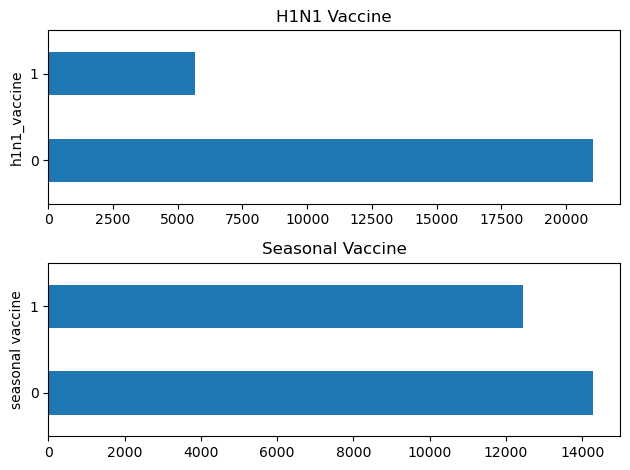

In [8]:
# class balance

import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(2, 1)


#H1N1 
train_targets_1['h1n1_vaccine'].value_counts().plot.barh(title="H1N1 Vaccine", ax=ax[0])
ax[0].set_ylabel("h1n1_vaccine")

#Seasonal Vaccine
train_targets_1['seasonal_vaccine'].value_counts().plot.barh(title="Seasonal Vaccine", ax=ax[1])
ax[1].set_ylabel("seasonal vaccine")

fig.tight_layout()

In [9]:
# as we can see, the flu vaccine values are pretty balanced, but h1n1 vaccines are highly imbalanced. will have to
# take account of this in our modeling. 

In [10]:
# explore nulls
train_features_1.isna().sum()


# setting nulls to be less than 5% if we're going to delete them.

lower_threshold_percentage = 0.0

upper_threshold_percentage = 0.05

# Calculate the percentage of null values for each column
null_percentages = train_features_1.isnull().sum() / len(train_features_1)
print(null_percentages)
filtered_columns = null_percentages[
    (null_percentages > lower_threshold_percentage) & (null_percentages < upper_threshold_percentage)
].index.tolist()

#print(filtered_columns)





# so we have quite a few columns where we can safely drop nulls, based on best practices. we assume this will map 
# to the test data. let's check 



respondent_id                  0.000000
h1n1_concern                   0.003445
h1n1_knowledge                 0.004343
behavioral_antiviral_meds      0.002658
behavioral_avoidance           0.007788
behavioral_face_mask           0.000711
behavioral_wash_hands          0.001573
behavioral_large_gatherings    0.003258
behavioral_outside_home        0.003070
behavioral_touch_face          0.004793
doctor_recc_h1n1               0.080878
doctor_recc_seasonal           0.080878
chronic_med_condition          0.036358
child_under_6_months           0.030704
health_worker                  0.030104
health_insurance               0.459580
opinion_h1n1_vacc_effective    0.014640
opinion_h1n1_risk              0.014528
opinion_h1n1_sick_from_vacc    0.014790
opinion_seas_vacc_effective    0.017299
opinion_seas_risk              0.019246
opinion_seas_sick_from_vacc    0.020107
age_group                      0.000000
education                      0.052683
race                           0.000000


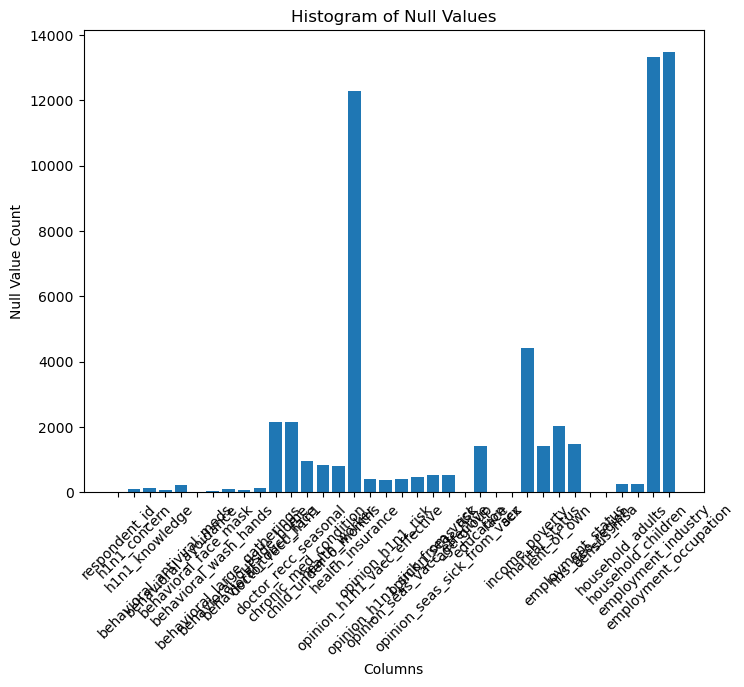

In [11]:
# let's visualize

null_counts = train_features_1.isnull().sum()

# Create a histogram of null values
plt.figure(figsize=(8, 6))
plt.bar(null_counts.index, null_counts.values)
plt.xlabel('Columns')
plt.ylabel('Null Value Count')
plt.title('Histogram of Null Values')
plt.xticks(rotation=45)
plt.show()





In [12]:
null_percentages_2 = test_features_1.isnull().sum() / len(train_features_1)

filtered_columns_2 = null_percentages_2 [
    (null_percentages_2  > lower_threshold_percentage) & (null_percentages_2  <= upper_threshold_percentage)
].index.tolist()


sorted(list(filtered_columns_2)) == sorted(list(filtered_columns))

# they're the same! so our training feature data is representative in respect to the nulls we can drop.

True

In [13]:
# let's go ahead and merge our training data, since we've established it's a represenative sample (relative to
# the other sample AKA test features)

In [14]:
# set indices
train_features_1 = train_features_1.set_index('respondent_id')
train_targets_1 = train_targets_1.set_index('respondent_id')

# merge

train_merged = train_features_1.merge(train_targets_1, on='respondent_id', how='inner')
train_merged.head()

train_merged.isna().sum()
train_merged.shape

(26707, 37)

In [15]:
train_merged.isna().sum()

# Drop null values from the filtered columns

merged_filtered = train_merged.dropna(subset=filtered_columns)
merged_filtered.head()
merged_filtered.shape
merged_filtered.isna().sum()

h1n1_concern                       0
h1n1_knowledge                     0
behavioral_antiviral_meds          0
behavioral_avoidance               0
behavioral_face_mask               0
behavioral_wash_hands              0
behavioral_large_gatherings        0
behavioral_outside_home            0
behavioral_touch_face              0
doctor_recc_h1n1                1827
doctor_recc_seasonal            1827
chronic_med_condition              0
child_under_6_months               0
health_worker                      0
health_insurance               10981
opinion_h1n1_vacc_effective        0
opinion_h1n1_risk                  0
opinion_h1n1_sick_from_vacc        0
opinion_seas_vacc_effective        0
opinion_seas_risk                  0
opinion_seas_sick_from_vacc        0
age_group                          0
education                        523
race                               0
sex                                0
income_poverty                  3284
marital_status                   522
r

In [16]:
# let's look both at zero values and nulls

def zeroes_and_nulls(df):
    zeroes = (df == 0.00).astype(int).sum(axis=0)
    nulls = df.isnull().sum()
    nulls_percent = 100 * df.isnull().sum() / len(df)
    zero_nulls_table = pd.concat([zeroes, nulls, nulls_percent], axis=1)
    zero_nulls_table = zero_nulls_table.rename(
        columns = {0:'Zero Values',
                   1:'Missing Values',
                   2:'% Missing of Total Values'})
    zero_nulls_table['Total Zero or Missing Values'] = zero_nulls_table['Zero Values'] + zero_nulls_table['Missing Values']
    zero_nulls_table['% Total Zero or Missing Values'] = 100 * zero_nulls_table['Total Zero or Missing Values'] / len(df)
    zero_nulls_table['Data Type'] = df.dtypes
    zero_nulls_table = zero_nulls_table[zero_nulls_table.iloc[:,1] != 0].sort_values( '% Missing of Total Values', ascending=False).round(1)
    
    return zero_nulls_table



In [17]:
zeroes_and_nulls(merged_filtered)

Zero Values  Missing Values  % Missing of Total Values  \
employment_occupation            0           11966                       48.2   
employment_industry              0           11839                       47.7   
health_insurance              1666           10981                       44.3   
income_poverty                   0            3284                       13.2   
doctor_recc_h1n1             17870            1827                        7.4   
doctor_recc_seasonal         15347            1827                        7.4   
rent_or_own                      0            1108                        4.5   
employment_status                0             571                        2.3   
education                        0             523                        2.1   
marital_status                   0             522                        2.1   

                       Total Zero or Missing Values  \
employment_occupation                         11966   
employment_industry                           11839   
health_insurance                              12647   
income_poverty                                 3284   
doctor_recc_h1n1                              19697   
doctor_recc_seasonal                          17174   
rent_or_own                                    1108   
employment_status                               571   
education                                       523   
marital_status                                  522   

                       % Total Zero or Missing Values Data Type  
employment_occupation                            48.2    object  
employment_industry                              47.7    object  
health_insurance                                 51.0   float64  
income_poverty                                   13.2    object  
doctor_recc_h1n1                                 79.4   float64  
doctor_recc_seasonal                             69.2   float64  
rent_or_own                                       4.5    object  
employment_status                                 2.3    object  
education                                         2.1    object  
marital_status                                    2.1    object

In [18]:
# hmmm, looks like we have even more columns with less than 5% nulls that we could maybe drop? 
# this indicates that certain null fields are correlated!

null_percentages_3 = merged_filtered.isnull().sum() / len(train_features_1)
filtered_columns_3 = null_percentages_3 [
    (null_percentages_3  > lower_threshold_percentage) & (null_percentages_3  <= upper_threshold_percentage)
].index.tolist()

# looking at how the null percentages changed after the first dropna. while I'm tempted to drop more, because
# of my concern about null correlations, I don't want to keep dropping and end up with very biased data

result = null_percentages_2[null_percentages_2.index.isin(null_percentages_3.index)] - null_percentages_3
print(result)

age_group                      0.000000
behavioral_antiviral_meds      0.002958
behavioral_avoidance           0.007975
behavioral_face_mask           0.000711
behavioral_large_gatherings    0.002696
behavioral_outside_home        0.003070
behavioral_touch_face          0.004793
behavioral_wash_hands          0.001498
census_msa                     0.000000
child_under_6_months           0.030441
chronic_med_condition          0.034897
doctor_recc_h1n1               0.012469
doctor_recc_seasonal           0.012469
education                      0.033100
employment_industry            0.053769
employment_occupation          0.054667
employment_status              0.033699
h1n1_concern                   0.003183
h1n1_knowledge                 0.004568
h1n1_vaccine                        NaN
health_insurance               0.046692
health_worker                  0.029543
hhs_geo_region                 0.000000
household_adults               0.008425
household_children             0.008425


In [19]:
# it also appears that the columns with zero values are likely simple binary classification.  let's look

print(merged_filtered.doctor_recc_h1n1.value_counts())
print(merged_filtered.doctor_recc_seasonal.value_counts())
print(merged_filtered.health_insurance.value_counts())

# yep, this clearly is the case with two of the columns full of zeroes. but what about health insurance? 
# it should be the same binary classifer, but why so many missing values? is it something that people would
# feel sensitive answering, like with specific information about employment? or maybe it's something to do with
# how the survey was structured? background info being towards the end, meaning the people who don't finish
# the survey would not provide this info? would be interesting to look at the survey itself.

0.0    17870
1.0     5106
Name: doctor_recc_h1n1, dtype: int64
0.0    15347
1.0     7629
Name: doctor_recc_seasonal, dtype: int64
1.0    12156
0.0     1666
Name: health_insurance, dtype: int64


In [20]:
#  maybe we're getting lost in the weeds. let's look at the profile report

sample = merged_filtered.sample(10000)

profile = ProfileReport(sample, minimal=True)
profile.to_file("output.html")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
# looking at the profile report, we see our data is highly skewed/non-normal, on top of all 
# the missing (and likely MNAR) values. we should probably normalize some of the values, but after the split? 

In [22]:
# imputing missing values or creating new columns? try the latter? for the big null categories


#columns_to_drop_na = ['health_insurance', 'employment_industry', 'employment_occupation']

#for column in columns_to_drop_na:
    #merged_filtered['{}_IsNull'.format(column)] = merged_filtered[column].isnull()
    

#merged_filtered.dropna(subset=columns_to_drop_na, inplace=True)

#merged_filtered.head()
#merged_filtered.shape



<AxesSubplot: >

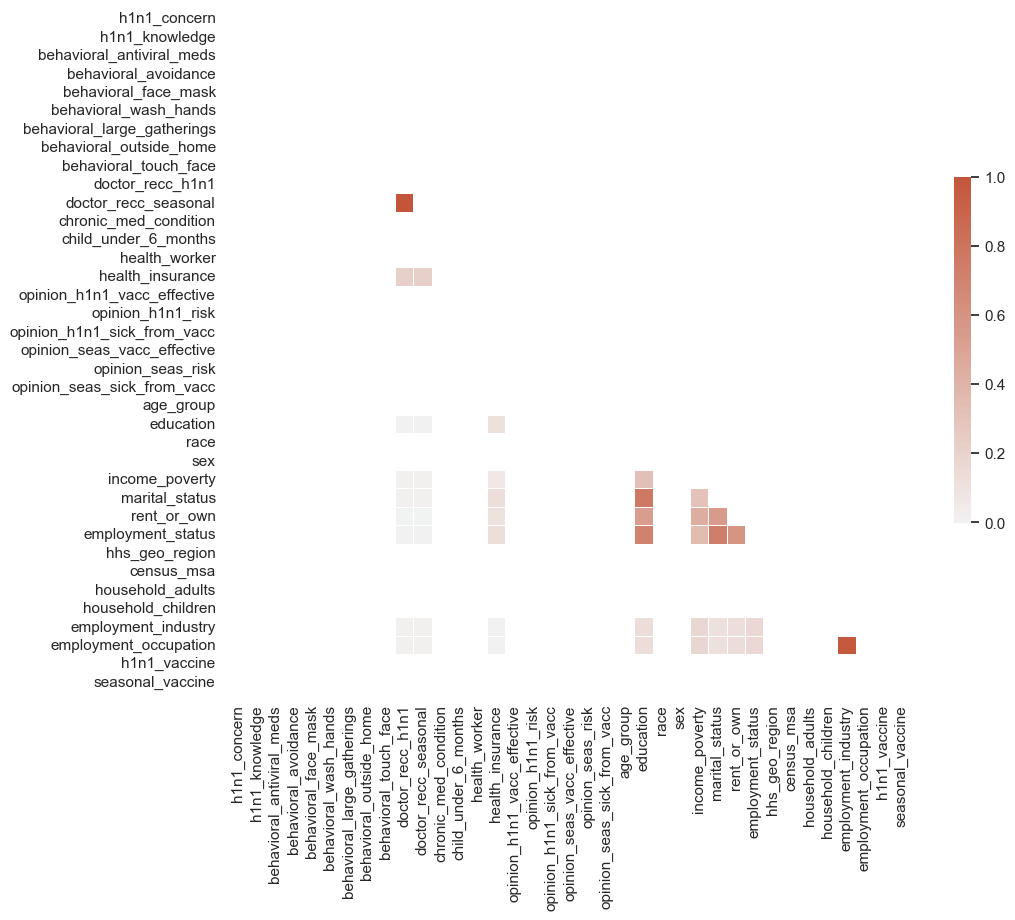

In [23]:
# hmmm, this doesn't seem right. now we only have a small fraction of our previous rows! 

# let's keep the missing data for now, especally since a good chunk of it appears MNAR (missing not at random)

# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3668100/

# we'll attempt to see statistically if the missing values are MNAR or not:

# R has something like this. Trying to find something in Python: https://rdrr.io/cran/finalfit/man/missing_pairs.html

from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")



# Compute the correlation matrix
corr = merged_filtered.isnull().corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


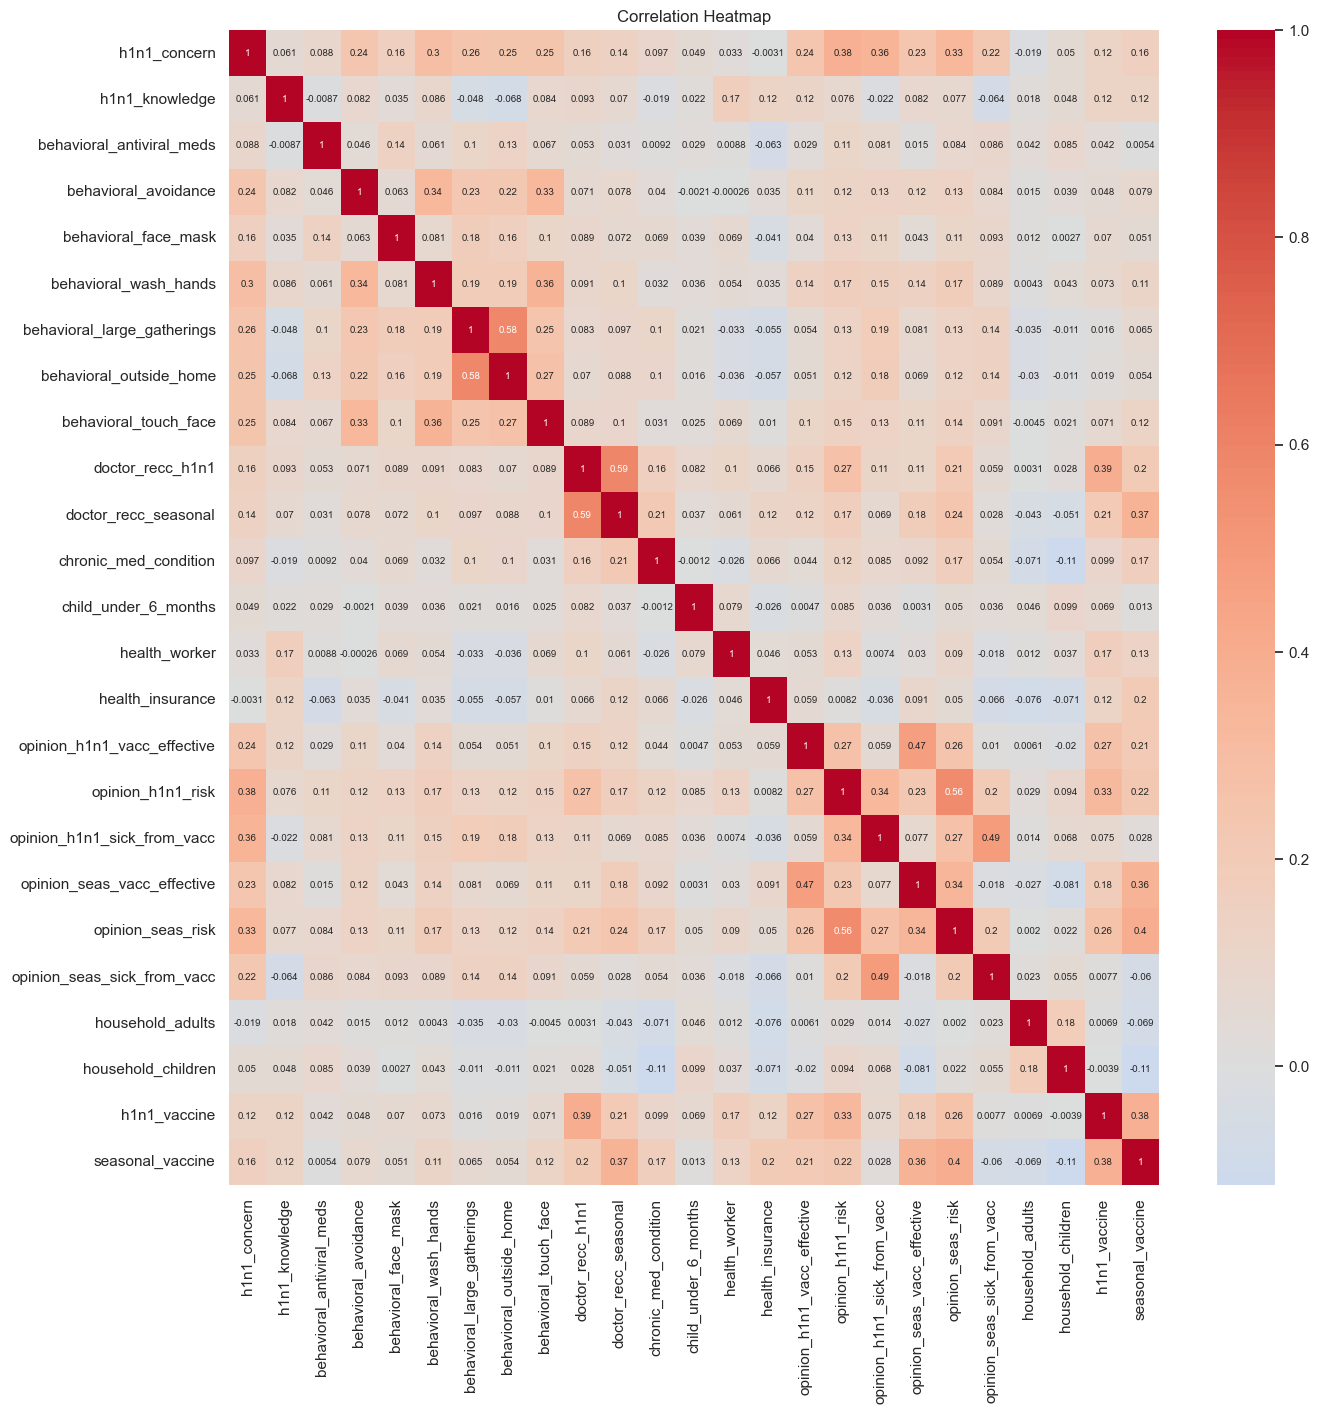

In [24]:
# hmmm, looks like the big employment category nulls are pretty strongly correlated with each other, and the health insurance 
# question is also moderately correlated with other nulls

# let's also look non-null correlated features and see if the same pattern applies?

corr = merged_filtered.corr()

# Plot heatmap
plt.figure(figsize = (15,15))
sns.heatmap(corr, center = 0, annot = True, annot_kws={"size": 35 / np.sqrt(len(corr))}, cmap = 'coolwarm')
plt.title('Correlation Heatmap')
plt.show()


# well, this is interesting but doesn't. help us much with understanding the relationships between
# the big null categories. because the data type doesn't work with heatmaps 


In [25]:
# i think we've gone as far as we can go with understanding our nulls (at least for now). 

# should we get rid of any collinear features? the "opininon" of risk columns are near .6, which is a typical
# threshhold for removal. let's get a vif score

y, X = dmatrices('h1n1_vaccine ~ opinion_h1n1_risk+opinion_seas_risk', data=merged_filtered, return_type='dataframe')


vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif



VIF           variable
0  5.623849          Intercept
1  1.466893  opinion_h1n1_risk
2  1.466893  opinion_seas_risk

In [26]:
# now let's do a vif for the other target variable

y, X = dmatrices('seasonal_vaccine ~ doctor_recc_seasonal+doctor_recc_h1n1', data=merged_filtered, return_type='dataframe')


vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif



VIF              variable
0  1.517967             Intercept
1  1.542967  doctor_recc_seasonal
2  1.542967      doctor_recc_h1n1

In [27]:
# vif scores aren't too bad (2-5 considered moderate). let's keep these features.

In [28]:
# let's look at the other moderately correlated features and get a VIF score


y, X = dmatrices('seasonal_vaccine ~ opinion_h1n1_risk+opinion_seas_risk', data=merged_filtered, return_type='dataframe')


vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif



VIF           variable
0  5.623849          Intercept
1  1.466893  opinion_h1n1_risk
2  1.466893  opinion_seas_risk

In [29]:

y, X = dmatrices('h1n1_vaccine ~ opinion_h1n1_risk+opinion_seas_risk', data=merged_filtered, return_type='dataframe')


vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif

VIF           variable
0  5.623849          Intercept
1  1.466893  opinion_h1n1_risk
2  1.466893  opinion_seas_risk

In [30]:
y, X = dmatrices('seasonal_vaccine ~ behavioral_outside_home+behavioral_large_gatherings', data=merged_filtered, return_type='dataframe')


vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif

VIF                     variable
0  1.673572                    Intercept
1  1.520031      behavioral_outside_home
2  1.520031  behavioral_large_gatherings

In [31]:
y, X = dmatrices('h1n1_vaccine ~ behavioral_outside_home+behavioral_large_gatherings', data=merged_filtered, return_type='dataframe')


vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif

VIF                     variable
0  1.673572                    Intercept
1  1.520031      behavioral_outside_home
2  1.520031  behavioral_large_gatherings

In [32]:
y, X = dmatrices('seasonal_vaccine ~ doctor_recc_h1n1+doctor_recc_seasonal', data=merged_filtered, return_type='dataframe')


vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif

VIF              variable
0  1.517967             Intercept
1  1.542967      doctor_recc_h1n1
2  1.542967  doctor_recc_seasonal

In [33]:
# explore data types and think about which transformations might be needed later 
y, X = dmatrices('h1n1_vaccine ~ doctor_recc_h1n1+doctor_recc_seasonal', data=merged_filtered, return_type='dataframe')


vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif


VIF              variable
0  1.517967             Intercept
1  1.542967      doctor_recc_h1n1
2  1.542967  doctor_recc_seasonal

In [34]:
# none of our VIF scores are bad, even though they heatmap suggests we should consider removing them. how
# do VIFs work with multilabel, multiclass targets?

In [35]:
# having handled nulls, multicollinearity, and zeroes (and briefly look at distributions), 
# let's also check out duplicates

duplicates = merged_filtered[merged_filtered.duplicated()]
print(len(duplicates))


# no duplicates! cool! 

0


In [36]:

# let's split the data!

columns_to_drop = ['h1n1_vaccine','seasonal_vaccine']

# set X and y

# transforming the multilabel target so it can be properly used by the models 

y = merged_filtered[['h1n1_vaccine', 'seasonal_vaccine']]


X = merged_filtered.drop(columns_to_drop, axis=1)

mlb = MultiLabelBinarizer()

y = mlb.fit_transform(y)





In [37]:

# X_train_transformed = preprocessor.fit_transform(X_train)
# X_train_transformed
# # transform to a dataframe to get a look at it
# X_train_transformed = pd.DataFrame(X_train_transformed)

# X_train_transformed.head()

In [38]:
# now that we have our split data, let's look at effect scores. we can trim and do some feature engineering.

# need to transform a few non-binary categorical columns, like occupation, etc
#X_train_, y_train = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# training transformations, possibly including logs, scaling,  get mapping data for hhs region?
# explore effect scores. use CatBoostClassifier with MultiCrossEntropy with Tensorflow? feature engineering!


In [39]:
num_cols = []
cat_cols = []


for i in X.columns:
    if X[i].dtype in ['float64', 'int64']:
        num_cols.append(i)
    elif X[i].dtype in ['object']:
        cat_cols.append(i)
    else:
        print("error")


In [40]:
# simple transform pipeline

num_transformer = Pipeline(steps=[
    ('standard', StandardScaler())
])                                  
cat_transformer = Pipeline(steps=[
    ('ohe_encoder', OneHotEncoder(drop="first", handle_unknown='ignore'))                     
])

In [41]:
# simple preprocess 
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols),
    ])



In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=1)


In [43]:
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", rfe),
])

In [46]:
from skmultilearn.model_selection import iterative_train_test_split
# http://videolectures.net/ecmlpkdd2011_tsoumakas_stratification/?q=stratification%20multi%20label
# was getting lots of errors. found solution here: https://github.com/scikit-multilearn/scikit-multilearn/issues/160

# this algorithm works for imbalanced multi-label target data
X_train, y_train, X_test, y_test = iterative_train_test_split(
    X.values,
    y.values,
    test_size = 0.2
)


AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
# toots 

In [ ]:
columns = X.columns

X_train = pd.DataFrame(X_train, columns=columns)
X_test = pd.DataFrame(X_test, columns=columns)

In [ ]:
full_pipeline.fit(X_train, y_train)

# Predict on evaluation set
# This competition wants probabilities, not labels
#preds = full_pipeline.predict(X_test)
#preds



In [ ]:
# feature importance using random forest regression
model = RandomForestClassifier() # XGBClassifier()
model.fit(X_train, y_train)
pd.DataFrame({'Variable':X.columns,
              'Importance':model.feature_importances_}).sort_values('Importance', ascending=False)


In [ ]:
# feature importance using XG Boost
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)
pd.DataFrame({'Variable':X.columns,
              'Importance':model.feature_importances_}).sort_values('Importance', ascending=False)


In [ ]:
# X_train.loc[:, rfe.support_]
#forest = RandomForestRegressor()
_ #= forest.fit(rfe.transform(X_train), y_train)
#forest.score(rfe.transform(X_test), y_test)

In [ ]:
well, we got a terrible score using random forest regression! i think this might be best with non-cagetorical data


In [ ]:





#cross_validate(clf, X_train, y_train, return_train_score=True)

# from operator import itemgetter
# features = X_train_transformed.columns.to_list()
# for x, y in (sorted(zip(rfe.ranking_ , features), key=itemgetter(0))):
#     print(x, y)
    
# n_features_to_select = 10
# rfe = RFE(regressor, n_features_to_select=n_features_to_select)
# rfe.fit(X_train_transformed, y_train)

# predictions = rfe.predict(X_test)


# received error stating RFE cannot handle NaNs encoded "natively". It recommends rn.ensemble.HistGradientBoostingClassifier and Regressor

In [ ]:
#from sklearn.ensemble import HistGradientBoostingClassifier 

In [ ]:
#clf = HistGradientBoostingClassifier(loss='categorical_crossentropy').fit(X_train_transformed, binary_target_train)
#clf.score(X_train_transformed, binary_target_train)

In [ ]:
CatBoostClassifer
#cat_features = [2]
#embedding_features=[0, 1]

#model = CatBoostClassifier(iterations=2,
                           learning_rate=1,
                           depth=2)
# Fit model
#model.fit(X_train, y_train, cat_features=cat_features, embedding_features=embedding_features)
# Get predicted classes
#preds_class = model.predict(eval_data)



In [ ]:
# test transformations

In [ ]:
# choose models. score models.
# models and methods to consider: sklearn.multioutput.MultiOutputClassifier, xgbooster, 

In [ ]:
# visualize output

In [ ]:
# build pipeline

In [ ]:
# visualize output